In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class State:
    """a container to hold an object"""

    def __init__(self, mass, x, y, u, v):
        self.mass = mass
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     self.x + other.x, self.y + other.y,
                     self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     self.x - other.x, self.y - other.y,
                     self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     other * self.x, other * self.y,
                     other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.mass:10.6f}: {self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

In [3]:
import collections

In [27]:
class SolarSystem:
    """model the gravitational interaction of a solar system."""

    def __init__(self, M_star, *, m_planets=None, a_planets=None,
                 max_history=50000, SMALL=1.e-30):

        self.G = 4 * np.pi**2  # units AU**3 / (solar mass * year**2)
        self.M_star = M_star

        # store the history of the solar system
        self.history = collections.deque(maxlen=max_history)

        # we have the star and planets
        self.nobjects = len(m_planets) + 1
        
        # current solar system
        system = []
        
        # store the star 
        system.append(State(M_star, 0.0, 0.0, 0.0, 0.0))

        # store the planets
        assert len(m_planets) == len(a_planets)

        for m, a in zip(m_planets, a_planets):
            # pick a random angle and then set the velocity to be circular
            phi = np.random.uniform(0, 2.0*np.pi)
            v_circ = np.sqrt(self.G * self.M_star / a)
            system.append(State(m,
                                a*np.cos(phi), a*np.sin(phi),
                                -v_circ*np.sin(phi), v_circ*np.cos(phi)))
        
        # now correct the star's state so the center of mass is
        # at the origin and motionless
        mx_cm = 0.0
        my_cm = 0.0
        mu_cm = 0.0
        mv_cm = 0.0
        
        for n in range(1, self.nobjects):
            mx_cm += system[n].mass * system[n].x
            my_cm += system[n].mass * system[n].y
            mu_cm += system[n].mass * system[n].u
            mv_cm += system[n].mass * system[n].v

        system[0].x = -mx_cm / M_star
        system[0].y = -my_cm / M_star
        system[0].u = -mu_cm / M_star
        system[0].v = -mv_cm / M_star
        
        # store the initial state
        self.history.append(system)

        self.SMALL = SMALL

        self.time = collections.deque([0.0], maxlen=max_history)

    def npts(self):
        """return the number of integration points"""
        return len(self.time)

    def rhs(self, states):
        """states is (State, State, ...)"""

        ydots = []

        for istar in range(len(states)):

            # compute the space derivatives

            dxdt = states[istar].u
            dydt = states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(states)):
                if istar == jstar:
                    continue
                else:
                    dx = states[jstar].x - states[istar].x
                    dy = states[jstar].y - states[istar].y

                    r = np.sqrt(dx**2 + dy**2) + self.SMALL

                    dudt += self.G * states[jstar].mass * dx / r**3
                    dvdt += self.G * states[jstar].mass * dy / r**3

            ydots.append(State(states[istar].mass, dxdt, dydt, dudt, dvdt))

        return ydots

    def single_step_verlet(self, states_old, dt):
        """take a single Verlet step (kick-drift-kick)"""

        ydot_old = self.rhs(states_old)

        states_new = []
        for istate in range(len(states_old)):
            
            # kick
            uhalf = states_old[istate].u + 0.5 * dt * ydot_old[istate].u
            vhalf = states_old[istate].v + 0.5 * dt * ydot_old[istate].v

            # drift
            xnew = states_old[istate].x + dt * uhalf
            ynew = states_old[istate].y + dt * vhalf            

            states_new.append(State(states_old[istate].mass,
                                    xnew, ynew,
                                    uhalf, vhalf))
            
        # evaluate the acceleration again -- this works only because
        # the acceleration does not depend on velocity
        ydot_new = self.rhs(states_new)

        for istate in range(len(states_new)):

            # kick
            states_new[istate].u += 0.5 * dt * ydot_new[istate].u
            states_new[istate].v += 0.5 * dt * ydot_new[istate].v            

        return states_new

    def single_step_yoshida(self, states_old, dt):
        """take a single step using the 4th order Yoshida integrator"""

        cbrt2 = np.cbrt(2)
        w0 = -cbrt2 / (2 - cbrt2)
        w1 = 1 / (2 - cbrt2)

        c1 = w1 / 2
        c2 = 0.5 * (w0 + w1)
        c3 = c2
        c4 = c1

        d1 = w1
        d2 = w0
        d3 = w1

        # we can just work on the "new" state directly, so start by
        # copying the old to new
        states_new = []
        for s in states_old:
            states_new.append(State(s.mass, s.x, s.y, s.u, s.v))
            
        # drift with current velocity
        for s in states_new:
            s.x += c1 * s.u * dt
            s.y += c1 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)
        
        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d1 * ydots[n].u * dt
            s.v += d1 * ydots[n].v * dt

            s.x += c2 * s.u * dt
            s.y += c2 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)

        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d2 * ydots[n].u * dt
            s.v += d2 * ydots[n].v * dt

            s.x += c3 * s.u * dt
            s.y += c3 * s.v * dt

        # evaluate the force
        ydots = self.rhs(states_new)

        # kick followed by drift
        for n, s in enumerate(states_new):
            s.u += d3 * ydots[n].u * dt
            s.v += d3 * ydots[n].v * dt

            s.x += c4 * s.u * dt
            s.y += c4 * s.v * dt

        return states_new

    def integrate(self, dt, tmax):
        """integrate our solar system using the velocity-Verlet method"""

        t = self.time[-1]
        
        while t < tmax:
            
            states_old = self.history[-1]

            if t + dt > tmax:
                dt = tmax-t

            states_new = self.single_step_yoshida(states_old, dt)

            t += dt
            
            self.time.append(t)
            self.history.append(states_new)

In [28]:
# these are roughly the HR 8799 planet orbits
m_planets = [0.0054, 0.0074, 0.0087, 0.0071]
a_planets = [71.6, 41.4, 26.7, 16.3]

In [37]:
s = SolarSystem(1.0, m_planets=m_planets, a_planets=a_planets)

In [38]:
s.integrate(0.05, 5000)

In [39]:
# matplotlib has trouble with lots of orbits
#import matplotlib
#matplotlib.rcParams['agg.path.chunksize'] = 1000

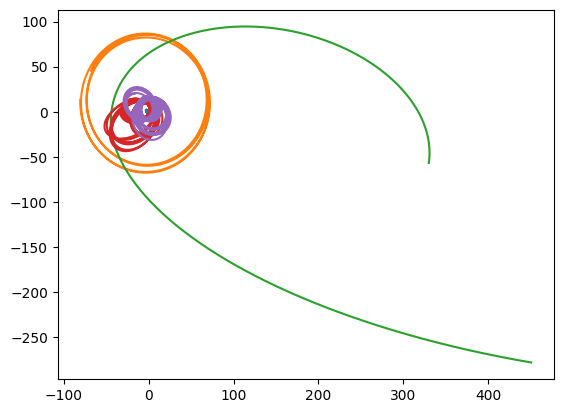

In [40]:
fig, ax = plt.subplots()

for n in range(s.nobjects):
    xs = [s.history[j][n].x for j in range(len(s.history))]
    ys = [s.history[j][n].y for j in range(len(s.history))]    
    ax.plot(xs, ys, label=f"{n}")

In [9]:
xs = [q[1].x for q in s.history]

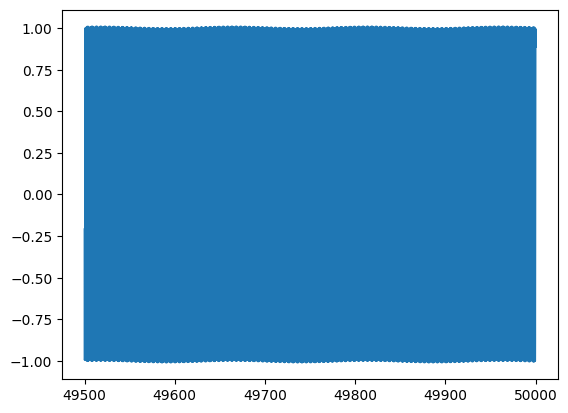

In [10]:
fig, ax = plt.subplots()
ax.plot(s.time, xs)